# Analisis exploratorio de los datos en Python

Librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.cloud import bigquery
from bq_helper import BigQueryHelper
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()  
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Probando conexión a GBQ

In [2]:
%load_ext google.cloud.bigquery

In [3]:
%%bigquery
SELECT * FROM `option-bigquery-example.titanic.titanic` LIMIT 10

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
1,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,None,S
2,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,None,S
3,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,None,S
4,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,None,S
5,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,None,S
6,675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0,None,S
7,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,None,S
8,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,None,S
9,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,None,S


Importando datos de GBQ como dataframe

In [4]:
QUERY='SELECT * FROM `option-bigquery-example.titanic.titanic` LIMIT 1000'
bq_assistant = BigQueryHelper('option-bigquery-example', 'titanic')
titanic = bq_assistant.query_to_pandas(QUERY)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
1,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,None,S
2,807,0,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0,A36,S
3,816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0,B102,S
4,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0,None,S


## Analizando dataset titanic

In [5]:
titanic.describe() # Descrición de los datos

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
titanic.info() # Información respecto al tipo de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [7]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

missing_data(titanic) # Valores en blanco

,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [8]:
encoder = LabelEncoder()
encoded_sex = encoder.fit_transform(titanic.iloc[:, 4])
titanic['Sex'] = encoded_sex

In [9]:
guess_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = titanic[(titanic['Sex'] == i) & \
                           
                              (titanic['Pclass'] == j+1)]['Age'].dropna()
        age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
        guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
for i in range(0, 2):
    for j in range(0, 3):
        titanic.loc[ (titanic.Age.isnull()) & (titanic.Sex == i) & (titanic.Pclass == j+1),\
                'Age'] = guess_ages[i,j]

titanic['Age'] = titanic['Age'].astype(int)

titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,264,0,1,"Harrison, Mr. William",1,40,0,0,112059,0.0,B94,S
1,634,0,1,"Parr, Mr. William Henry Marsh",1,40,0,0,112052,0.0,None,S
2,807,0,1,"Andrews, Mr. Thomas Jr",1,39,0,0,112050,0.0,A36,S
3,816,0,1,"Fry, Mr. Richard",1,40,0,0,112058,0.0,B102,S
4,823,0,1,"Reuchlin, Jonkheer. John George",1,38,0,0,19972,0.0,None,S


# Explorando los datos

In [10]:
titanic[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Pclass', ascending=False)

,Pclass,Survived
2,3,0.242363
1,2,0.472826
0,1,0.629630


In [11]:
titanic[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Sex', ascending=False)

,Sex,Survived
1,1,0.188908
0,0,0.742038


In [12]:
titanic['AgeBand'] = pd.cut(titanic['Age'], 5)
titanic[['AgeBand', 'Survived','Sex']].groupby(['AgeBand','Sex'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Sex,Survived
0,"(-0.08, 16.0]",0,0.673469
1,"(-0.08, 16.0]",1,0.431373
2,"(16.0, 32.0]",0,0.703030
3,"(16.0, 32.0]",1,0.154545
4,"(32.0, 48.0]",0,0.815789
5,"(32.0, 48.0]",1,0.192857
6,"(48.0, 64.0]",0,0.916667
7,"(48.0, 64.0]",1,0.177778
8,"(64.0, 80.0]",0,NaN
9,"(64.0, 80.0]",1,0.090909


In [13]:
del titanic['AgeBand']

In [14]:
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Almacenando en bigquery

In [15]:
titanic.to_gbq('titanic.final','option-bigquery-example')

1it [00:05,  5.06s/it]


## Clustering
Como primera aproximación para entender y poder generar insights de la información entregada, se prueba mediante clusterinzación, tratando de identificar patrones y grupos importantes dentro de los pasajeros 

In [16]:
titanicluster=titanic.fillna(0)

In [17]:
titanicluster.head()
titanicluster=titanicluster[['Survived','Pclass','Sex','Age','SibSp','Parch']]

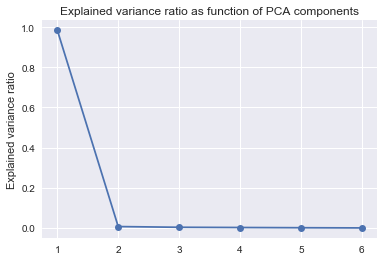

In [18]:
titanic_pca = PCA(n_components=6)
titanic_pca.fit(titanicluster)
test = titanic_pca.transform(titanicluster)
plt.plot([1,2,3,4,5,6],list(titanic_pca.explained_variance_ratio_),'-o')
plt.title('Explained variance ratio as function of PCA components')
plt.ylabel('Explained variance ratio')
plt.show()

In [19]:
reduction_pca = PCA(n_components=2)
reduced_features = reduction_pca.fit_transform(titanicluster)

In [20]:
km = KMeans(n_clusters=5)
clusters = km.fit(reduced_features)

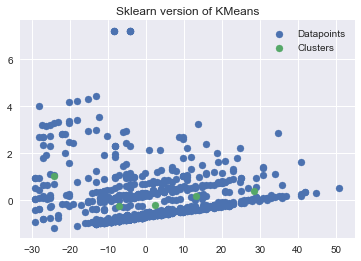

In [21]:
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], label='Datapoints')
plt.scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 1], label='Clusters')
plt.title("Sklearn version of KMeans")
plt.legend()
plt.show()

hay que buscar el mejor K para describir y agrupar los datos

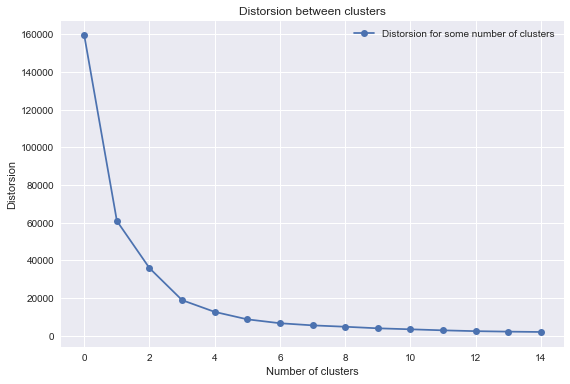

In [22]:
cluster_distorsion = []
for i in range(1, 16):
    test_sklearn = KMeans(n_clusters=i)
    test_sklearn.fit(reduced_features)
    cluster_distorsion.append(test_sklearn.inertia_)
plt.figure(figsize=(9, 6))
plt.plot(cluster_distorsion, marker='o', label='Distorsion for some number of clusters')
plt.title("Distorsion between clusters")
plt.xlabel('Number of clusters')
plt.ylabel("Distorsion")
plt.legend()
plt.show()

Del grafico anterior (elbow method) se puede ver que un buen K podria ser 4

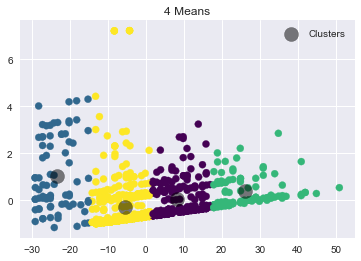

In [23]:
km = KMeans(n_clusters=4)
clusters = km.fit(reduced_features)
y_kmeans = km.predict(reduced_features)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1],c=y_kmeans, s=50, cmap='viridis')
centers = clusters.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,label='Clusters');
plt.title("4 Means")
plt.legend()
plt.show()

In [24]:
km = KMeans(n_clusters=4)
clusters = km.fit(titanicluster)
y_kmeans = km.predict(titanicluster)

In [25]:
titanicluster['cluster']=y_kmeans

In [26]:
cluster1=titanicluster[titanicluster['cluster']==0]
cluster1.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,cluster
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.0
mean,0.376238,1.564356,0.702970,54.891089,0.316832,0.277228,0.0
std,0.486857,0.767018,0.459229,7.266225,0.508541,0.694533,0.0
min,0.000000,1.000000,0.000000,46.000000,0.000000,0.000000,0.0
25%,0.000000,1.000000,0.000000,49.000000,0.000000,0.000000,0.0
50%,0.000000,1.000000,1.000000,53.000000,0.000000,0.000000,0.0
75%,1.000000,2.000000,1.000000,60.000000,1.000000,0.000000,0.0
max,1.000000,3.000000,1.000000,80.000000,2.000000,4.000000,0.0


In [27]:
cluster1[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.491803
1,2,0.304348
2,3,0.058824


In [28]:
cluster1[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,0,0.866667
1,1,0.169014


In [29]:
cluster2=titanicluster[titanicluster['cluster']==1]
cluster2.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,cluster
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.0
mean,0.331081,2.614865,0.657658,22.959459,0.463964,0.265766,1.0
std,0.471133,0.680496,0.475029,3.523308,1.183429,0.649083,0.0
min,0.000000,1.000000,0.000000,15.000000,0.000000,0.000000,1.0
25%,0.000000,2.000000,0.000000,21.000000,0.000000,0.000000,1.0
50%,0.000000,3.000000,1.000000,24.000000,0.000000,0.000000,1.0
75%,1.000000,3.000000,1.000000,25.000000,1.000000,0.000000,1.0
max,1.000000,3.000000,1.000000,29.000000,8.000000,4.000000,1.0


In [30]:
cluster2[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.740000
1,2,0.436620
2,3,0.244582


In [31]:
cluster2[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,0,0.710526
1,1,0.133562


In [32]:
cluster3=titanicluster[titanicluster['cluster']==2]
cluster3.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,cluster
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.0
mean,0.417910,1.988806,0.652985,36.261194,0.320896,0.339552,2.0
std,0.494138,0.858896,0.476911,4.568954,0.541889,0.936366,0.0
min,0.000000,1.000000,0.000000,30.000000,0.000000,0.000000,2.0
25%,0.000000,1.000000,0.000000,32.000000,0.000000,0.000000,2.0
50%,0.000000,2.000000,1.000000,36.000000,0.000000,0.000000,2.0
75%,1.000000,3.000000,1.000000,40.000000,1.000000,0.000000,2.0
max,1.000000,3.000000,1.000000,45.000000,3.000000,6.000000,2.0


In [33]:
cluster3[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.650000
1,2,0.422535
2,3,0.175258


In [34]:
cluster3[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,0,0.806452
1,1,0.211429


In [35]:
cluster4=titanicluster[titanicluster['cluster']==3]
cluster4.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,cluster
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.0
mean,0.576923,2.628205,0.500000,5.743590,1.820513,1.320513,3.0
std,0.497245,0.605365,0.503236,4.391361,1.649428,0.654526,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.0
25%,0.000000,2.000000,0.000000,2.000000,0.250000,1.000000,3.0
50%,1.000000,3.000000,0.500000,4.000000,1.000000,1.000000,3.0
75%,1.000000,3.000000,1.000000,9.000000,3.750000,2.000000,3.0
max,1.000000,3.000000,1.000000,14.000000,5.000000,2.000000,3.0


In [36]:
cluster4[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
1,2,1.000000
0,1,0.800000
2,3,0.407407


In [37]:
cluster4[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,0,0.615385
1,1,0.538462


# ML models
A continuación se generan un par de modelos utilizando cross validation para obtener los accuracys

In [38]:
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [39]:
titanic['IsAlone'] = 0
titanic.loc[titanic['FamilySize'] == 1, 'IsAlone'] = 1
titanic[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [40]:
titanic = titanic.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,IsAlone
0,264,0,1,"Harrison, Mr. William",1,40,112059,0.0,B94,S,1
1,634,0,1,"Parr, Mr. William Henry Marsh",1,40,112052,0.0,None,S,1
2,807,0,1,"Andrews, Mr. Thomas Jr",1,39,112050,0.0,A36,S,1
3,816,0,1,"Fry, Mr. Richard",1,40,112058,0.0,B102,S,1
4,823,0,1,"Reuchlin, Jonkheer. John George",1,38,19972,0.0,None,S,1


In [41]:
titanic['Embarked'] = titanic['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} )

In [42]:
titanic=titanic[['Survived','Pclass','Sex','Age','Embarked','IsAlone']]

In [43]:
titanic.dropna(inplace=True)
data=titanic.drop('Survived',axis=1)
titanickey=titanic['Survived']

In [44]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, data,titanickey , cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

C:\Users\FelipeBahamonde\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FelipeBahamonde\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FelipeBahamonde\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FelipeBahamonde\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\FelipeBahamonde\AppData\Roaming\Python\Python36\site-pa

Accuracy: 0.75 (+/- 0.15)


In [45]:
decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, data,titanickey , cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.67 (+/- 0.18)


In [46]:
random_forest = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(random_forest, data,titanickey , cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.18)


De los tres modelos anteriores se puede ver que el mejor desempeño se obtiene con regresión logistica. Cabe destacar que no se realizo ningun ajuste de parametros, simplemente se generan como ejemplo.